In [1]:
import glob
import copy

import xarray as xr
from xclim import sdba
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import xesmf as xe
#rom dask.distributed import Client, LocalCluster

In [2]:
import dask.diagnostics
dask.diagnostics.ProgressBar().register()

In [3]:
#dask.config.set(temporary_directory='/g/data/wp00/dbi599')

In [4]:
#cluster = LocalCluster(n_workers=1)
#client = Client(cluster)

In [5]:
#client

In [6]:
hist_start = '1986-01-01'
hist_end = '2005-12-31'

In [7]:
rcp_start = '2021-01-01'
rcp_end = '2040-12-31'

## Obs data

In [17]:
#obs_files = glob.glob('/g/data/xv83/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_*.nc')
obs_files = glob.glob('/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_*.nc')
obs_files.sort()

In [18]:
obs_files

['/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_19100101-19101231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_19110101-19111231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_19120101-19121231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_19130101-19131231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_19140101-19141231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_19150101-19151231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_19160101-19161231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_19170101-19171231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_19180101-19181231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_19190101-19191231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_19200101-19201231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_19210101-19211231_daily.nc',
 '/g/data/xv83/agcd-csiro/tm

In [19]:
ds_obs = xr.open_mfdataset(obs_files)
ds_obs = ds_obs.sel({'time': slice(hist_start, hist_end)}) #'lon': slice(110, 115)})
da_obs = ds_obs['tmax']
da_obs = da_obs.chunk({'time': -1})
da_obs.attrs['units'] = 'C'
da_obs

<xarray.DataArray 'tmax' (time: 7305, lat: 691, lon: 886)>
dask.array<rechunk-merge, shape=(7305, 691, 886), dtype=float32, chunksize=(7305, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * time     (time) datetime64[ns] 1986-01-01T09:00:00 ... 2005-12-31T09:00:00
Attributes:
    standard_name:              air_temperature
    long_name:                  Daily maximum air temperature
    units:                      C
    cell_methods:               time: maximum
    analysis_version_number:    2.01
    source:                     Interpolated surface observations
    frequency:                  daily
    length_scale_for_analysis:  250.0
    analysis_time:              2018-08-16 23:45:40 UTC

In [20]:
#time_adjustment = da_rcp_hbt['time'].values[0] - qq_obs_hbt['time'].values[0]
#time_adjustment

In [21]:
#qq_obs_hbt = qq_obs_hbt.assign_coords({'time': qq_obs_hbt['time'].values + time_adjustment})

Then follow [these instructions](https://xclim.readthedocs.io/en/stable/notebooks/sdba-advanced.html#Initializing-an-Adjustment-object-from-a-training-dataset) to use `QuantileDeltaMapping` to open the adjustment factor file and use it to perform the adjustment.

In [22]:
ds = xr.open_dataset("/g/data/wp00/dbi599/test_qqscale_adjustment.nc")
qm = sdba.QuantileDeltaMapping.from_dataset(ds)

In [23]:
qm.ds['af']

<xarray.DataArray 'af' (quantiles: 100, month: 12, lat: 145, lon: 192)>
[33408000 values with dtype=float32]
Coordinates:
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * quantiles  (quantiles) float64 0.005 0.015 0.025 0.035 ... 0.975 0.985 0.995
    height     float64 ...
Attributes:
    standard_name:  Adjustment factors
    long_name:      Quantile mapping adjustment factors

In [24]:
regridder = xe.Regridder(
    qm.ds,
    ds_obs,
    "bilinear"
)

In [25]:
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_145x192_691x886.nc 
Reuse pre-computed weights? False 
Input grid shape:           (145, 192) 
Output grid shape:          (691, 886) 
Periodic in longitude?      False

In [26]:
qm.ds = regridder(qm.ds)

In [27]:
qm.ds

<xarray.Dataset>
Dimensions:    (quantiles: 100, month: 12, lat: 691, lon: 886)
Coordinates:
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * quantiles  (quantiles) float64 0.005 0.015 0.025 0.035 ... 0.975 0.985 0.995
    height     float64 1.5
  * lon        (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
  * lat        (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
Data variables:
    af         (quantiles, month, lat, lon) float32 0.7826 0.7851 ... 0.8551
    hist_q     (quantiles, month, lat, lon) float32 10.2 10.2 ... 29.79 29.79
Attributes:
    regrid_method:  bilinear

In [28]:
qm.ds.isel({'lon': [0,1,2,3,4,5]})

<xarray.Dataset>
Dimensions:    (quantiles: 100, month: 12, lat: 691, lon: 6)
Coordinates:
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * quantiles  (quantiles) float64 0.005 0.015 0.025 0.035 ... 0.975 0.985 0.995
    height     float64 1.5
  * lon        (lon) float32 112.0 112.1 112.1 112.2 112.2 112.2
  * lat        (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
Data variables:
    af         (quantiles, month, lat, lon) float32 0.7826 0.7851 ... 0.8879
    hist_q     (quantiles, month, lat, lon) float32 10.2 10.2 ... 29.84 29.85
Attributes:
    regrid_method:  bilinear

In [20]:
qm.ds = qm.ds.compute()

In [21]:
#da_obs = da_obs.compute()

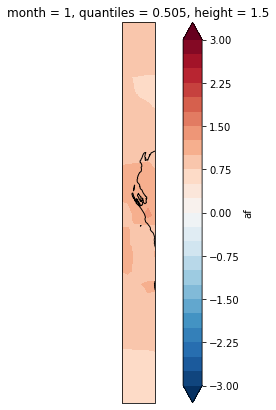

In [22]:
fig = plt.figure(figsize=[10, 7])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
qm.ds['af'].isel({'month': 0, 'quantiles': 50}).plot(
    ax=ax,
    cmap='RdBu_r',
    transform=ccrs.PlateCarree(),
    extend='both',
    levels=np.arange(-3, 3.1, 0.25),
)
ax.coastlines()
plt.show()

In [23]:
qm.ds

<xarray.Dataset>
Dimensions:    (quantiles: 100, month: 12, lat: 691, lon: 61)
Coordinates:
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * quantiles  (quantiles) float64 0.005 0.015 0.025 0.035 ... 0.975 0.985 0.995
    height     float64 1.5
  * lon        (lon) float32 112.0 112.1 112.1 112.2 ... 114.8 114.9 114.9 115.0
  * lat        (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
Data variables:
    af         (quantiles, month, lat, lon) float32 0.7826 0.7851 ... 0.7946
    hist_q     (quantiles, month, lat, lon) float32 10.2 10.2 ... 30.26 30.27
Attributes:
    regrid_method:  bilinear

In [24]:
qq_obs = qm.adjust(
    da_obs,
    extrapolation="constant",
    interp="linear"
)

In [25]:
#qq_obs = qq_obs.assign_coords({'time': qq_obs['time'].values + time_adjustment})

In [26]:
qq_obs = qq_obs.rename('tmax')
qq_obs = qq_obs.transpose('time', 'lat', 'lon')
qq_obs

<xarray.DataArray 'tmax' (time: 7305, lat: 691, lon: 61)>
dask.array<transpose, shape=(7305, 691, 61), dtype=float32, chunksize=(7305, 691, 61), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * time     (time) datetime64[ns] 1986-01-01T09:00:00 ... 2005-12-31T09:00:00
  * lon      (lon) float64 112.0 112.1 112.1 112.2 ... 114.8 114.9 114.9 115.0
    height   float64 1.5
Attributes:
    cell_methods:               time: maximum
    units:                      C
    analysis_version_number:    2.01
    long_name:                  Daily maximum air temperature
    standard_name:              air_temperature
    frequency:                  daily
    length_scale_for_analysis:  250.0
    grid_mapping:               crs
    coverage_content_type:      physicalMeasurement
    valid_range:                [-100.  100.]
    history:                    [2022-05-06 08:37:31] : Bias-adjusted with Em...
    bias_adjustment:            EmpiricalQuantileMapping(group=Grouper(add_di...

In [27]:
with dask.diagnostics.Profiler() as prof, dask.diagnostics.ResourceProfiler() as rprof:
    qq_obs = qq_obs.compute()

[########################################] | 100% Completed | 32min  2.3s


In [28]:
prof.visualize()

Figure(id='1002', ...)

In [29]:
rprof.visualize()

Figure(id='1277', ...)

In [ ]:
# qq_obs.sel({'time': slice('1986-01-01', '1986-12-31')}).to_netcdf('/g/data/wp00/dbi599/test_qqscale.nc')